In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
from src.configuration.aws_connection import S3Client
from io import StringIO
from src.constant import MODEL_BUCKET_NAME
from src.constant import FILE_KEY

s3_client = S3Client()

def fetch_file_from_s3(file_key):
        """Fetches a CSV file from the S3 bucket and returns it as a Pandas DataFrame."""
        try:
            obj = s3_client.s3_client.get_object(Bucket=MODEL_BUCKET_NAME, Key=file_key)
            df = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8')))
            return df
        
        except Exception as e:
            return None

data = fetch_file_from_s3(FILE_KEY)

In [4]:
data.head()

,review,sentiment
0,Film version of Sandra Bernhard's one-woman of...,negative
1,I switched this on (from cable) on a whim and ...,positive
2,The `plot' of this film contains a few holes y...,negative
3,"Some amusing humor, some that falls flat, some...",negative
4,What can you say about this movie? It was not ...,negative


In [ ]:
data = pd.read_csv("../data/IMDB.csv",nrows=1000)
data.head()

,review,sentiment
0,Film version of Sandra Bernhard's one-woman of...,negative
1,I switched this on (from cable) on a whim and ...,positive
2,The `plot' of this film contains a few holes y...,negative
3,"Some amusing humor, some that falls flat, some...",negative
4,What can you say about this movie? It was not ...,negative


In [16]:
data.shape

(1000, 2)

In [17]:
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [18]:
data.duplicated().sum()

np.int64(0)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1000 non-null   object
 1   sentiment  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [20]:
data["sentiment"] = data["sentiment"].map({"positive":1,"negative":0})

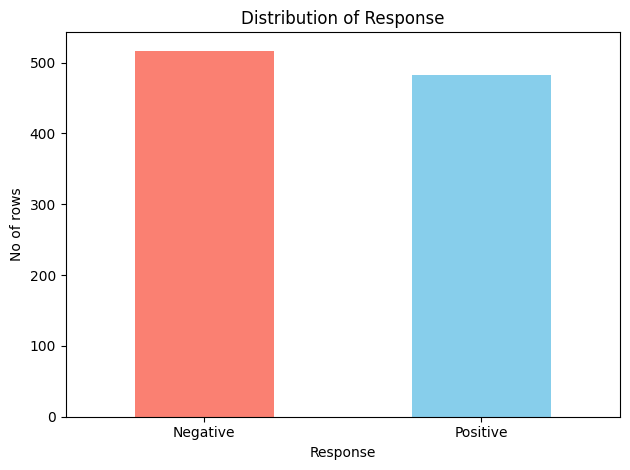

In [22]:
data["sentiment"].value_counts().plot(kind="bar",color=["salmon", "skyblue"])
plt.xticks(ticks=[0,1],labels=["Negative","Positive"],rotation=0)
plt.title("Distribution of Response")
plt.ylabel("No of rows")
plt.xlabel("Response")
plt.tight_layout()
plt.show()

In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download("wordnet")

wn = WordNetLemmatizer()
sw = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hasee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove links (http, https, www)
    text = re.sub(r'[^a-zA-Z\s]', " ", text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower().split()
    text = " ".join(wn.lemmatize(word) for word in text if word not in sw )
    return text

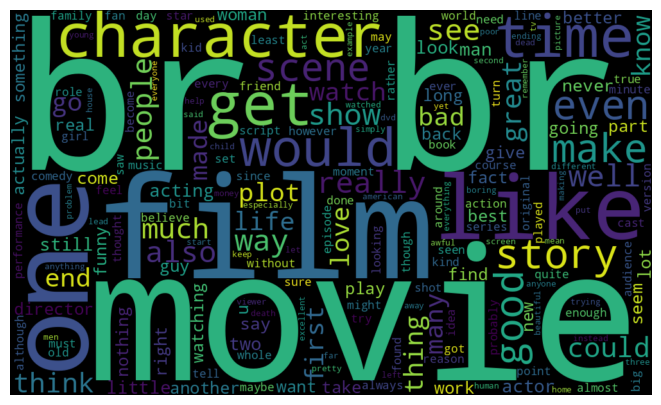

In [ ]:
from wordcloud import WordCloud
sw = set(stopwords.words("english"))
word = " ".join(word for word in data["review"])
cloud = WordCloud(width=1000,height=600,background_color="black",stopwords=sw,max_words=200).generate(word)

plt.figure(figsize=(13,5))
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [45]:
x = data.drop("sentiment", axis=1)
y = data["sentiment"]

#x=data["review"]
#y=data.iloc[:,-1]
x.shape,y.shape

((1000, 1), (1000,))

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score,precision_score,f1_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [55]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [2]:
import dagshub,mlflow
from dotenv import load_dotenv
load_dotenv()
import os

mlflow.set_tracking_uri(os.getenv("DAGSHUB_MLFLOW_TRACKING_URI"))
dagshub.init(repo_owner=os.getenv("DAGSHUB_REPO_OWNER"), repo_name=os.getenv("DAGSHUB_REPO_NAME"), mlflow=True)

mlflow.set_experiment("random_forest")

Initialized MLflow to track repo "haseebmanzoor1511/IMDB-Movie-Review-Sentiment-Anaysis-End-to-End"

Repository haseebmanzoor1511/IMDB-Movie-Review-Sentiment-Anaysis-End-to-End initialized!

<Experiment: artifact_location='mlflow-artifacts:/0936ce55fc0941f2a0dd4a9a2dc46346', creation_time=1751833117346, experiment_id='0', last_update_time=1751833117346, lifecycle_stage='active', name='random_forest', tags={}>

In [ ]:
text_pipline = Pipeline(steps=[
    ("clean_text", FunctionTransformer(lambda x: x.apply(clean_text))),
    ("tfidf", TfidfVectorizer(max_features=100))
])

#we apply the above text_pipeline on the below column ...because you can't apply 2 transformers to the same column
column = ColumnTransformer(transformers=[
    ("text_pipeline", text_pipline, "review")
])


pipe = Pipeline(steps=[
    ("column", column),
    ("classifier", RandomForestClassifier(random_state=42,n_estimators=100,max_depth=10))
])

In [82]:
import mlflow.sklearn

with mlflow.start_run(run_name="imdb_rf_run"):
    try:
        # Fit the pipeline
        pipe.fit(x_train, y_train)

        # Predict
        y_pred = pipe.predict(x_test)

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')

        #Log Parameters
        mlflow.log_param("Vectorizer","Tfidf-Vectorizer")
        mlflow.log_param("Model","RandomForest")
        mlflow.log_param("vectorizer_max_features", 100)
        mlflow.log_param("random_forest_n_estimators", 100)
        mlflow.log_param("random_forest_max_depth", 10)

        # Log Metircs
        mlflow.log_metric("test_accuracy", acc)
        mlflow.log_metric("test_precision", precision)
        mlflow.log_metric("test_f1", f1)

        #log train test size
        mlflow.log_param("train_size", len(x_train))
        mlflow.log_param("test_size", len(x_test))

        mlflow.log_param("random_seed", 42)

        mlflow.set_tag("project", "IMDB Sentiment")

        # loading a model you already logged 
        # mlflow.sklearn.log_model(pipe, name="model")

        #log the notebook file
        mlflow.log_artifact(r"C:\Users\hasee\Desktop\IMDB-Movie-Review-Sentiment-Anaysis-End-to-End\notebook\experiment.ipynb")


        # ✅ Save classification report as artifact
        report = classification_report(y_test, y_pred)
        with open("classification_report.txt", "w") as f:
            f.write(report)
        mlflow.log_artifact("classification_report.txt")
        print("Accuracy:", acc)
        print("Precision:", precision)
        print("F1 Score:", f1)
    except Exception as e:
        print(f"Error occured {e}")


Accuracy: 0.685
Precision: 0.6896551724137931
F1 Score: 0.6557377049180327
🏃 View run imdb_rf_run at: https://dagshub.com/haseebmanzoor1511/IMDB-Movie-Review-Sentiment-Anaysis-End-to-End.mlflow/#/experiments/0/runs/3d886f2e5392438084bf0feb0f9d9533
🧪 View experiment at: https://dagshub.com/haseebmanzoor1511/IMDB-Movie-Review-Sentiment-Anaysis-End-to-End.mlflow/#/experiments/0


## Simple Pipeline

In [ ]:
text_pipline = Pipeline(steps=[
    ("clean_text", FunctionTransformer(lambda x: x.apply(clean_text))),
    ("tfidf", TfidfVectorizer(max_features=100))
])

#we apply the above text_pipeline on the below column ...because you can't apply 2 transformers to the same column
column = ColumnTransformer(transformers=[
    ("text_pipeline", text_pipline, "review")
])


pipe = Pipeline(steps=[
    ("column", column),
    ("classifier", RandomForestClassifier(random_state=42,n_estimators=100,max_depth=10))
])

In [ ]:
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))
print(precision_score(y_test,y_pred))   # for multiclass labels, add average='macro' or average='weighted':

0.77
0.7777777777777778
0.7526881720430108
